# Exercise 4 - Tone mapping

In [1]:
# Group Number: 03
# Group Members: Kurt Kilian Eifler, Moritz Ladwig, Simon Grünewald

# Imports
import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy import misc
from scipy import fftpack
import skimage
import imageio

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = (16.0, 8.0)

# for 16 bit PNG support in imageio if needed, imageio.plugins.freeimage.download() might need to be run once per system (or exr/hdr/pgm/ppm support)

In [2]:
# Some useful functions
# Apply matrix to image
def applyColorMatrix(values, mat):
    tmp = values.reshape(-1, 3)
    tmp = np.matmul(tmp, mat)
    return np.reshape(tmp, values.shape)

# sRGB nonlinearity
def lin2srgb(x):
    result = np.zeros(x.shape)
    result[x >  0.0031308] = 1.055 * np.power(x[x > 0.0031308], 1/2.4) - 0.055
    result[x <= 0.0031308] = 12.92 * x[x <= 0.0031308]
    return result

# sRGB nonlinearity
def srgb2lin(x):
    result = np.zeros(x.shape)
    result[x >  0.04045] = np.power((x[x >  0.04045] + 0.055)/1.055, 2.4)
    result[x <= 0.04045] = x[x <= 0.04045]/12.92
    return result

# Plot the tonemapping curves that you will implement later
def curvePlot(x, y, y_additional = None):
    oneline = np.ones(x.shape)

    plt.plot(x, y, 'g')
    if not y_additional is None:
        plt.plot(x, y_additional, 'c')
    
    plt.plot(x, x, 'r:')
    plt.plot(x, oneline, 'w:', label='Monitor white')
    plt.plot(x, 0.001*oneline, 'w:', label='Monitor black')
    plt.plot(x, 0.0001*oneline, 'w:', label='Cine black')
    plt.plot(x, oneline, 'w:', label='Monitor white')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('HDR input')
    plt.ylabel('HDR output')
    plt.grid()

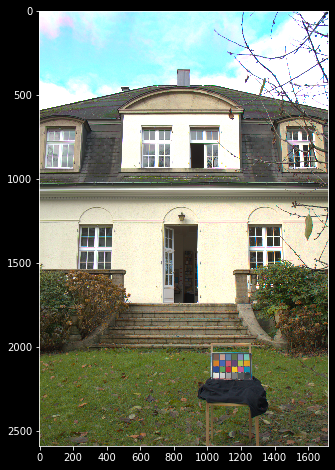

In [5]:
# Load the characterized image
img = np.load('../Ex_3/hdr_image_pinv.npy')

# Plot to verify everything looks as expected
plt.style.use('dark_background')
plt.imshow( lin2srgb( img ).clip( 0.0, 1.0 ) );

## 4.1 Tone mapping

When displaying your images by simply adjusting exposure, but clipping all values beyond 1 you may have noticed nasty artifacts. To get a better representation of high dynamic range images on standard dynamic range monitors several tone-mapping operators exist.

### 4.1.1 Simple log

Finish the anonymous function TM_Log2 that allows you to display a specified number of stops below peak white on your monitor:

\begin{equation*}
y = \frac{\log_2(\max(\epsilon_M, \frac{x}{\max(x)}))}{P_{stops}} + 1 \\ \\
x\in\mathbb{R}^+, P_{stops}\in\mathbb{R}^+, \epsilon_M \in\mathbb{R}+
\end{equation*}

Note: While most tone mapping algorithms map from linear space to linear space to be independent from the monitor EOTF this special tone mapper directly maps to display space.

(2591, 1722, 3)
(2591, 1722, 3)


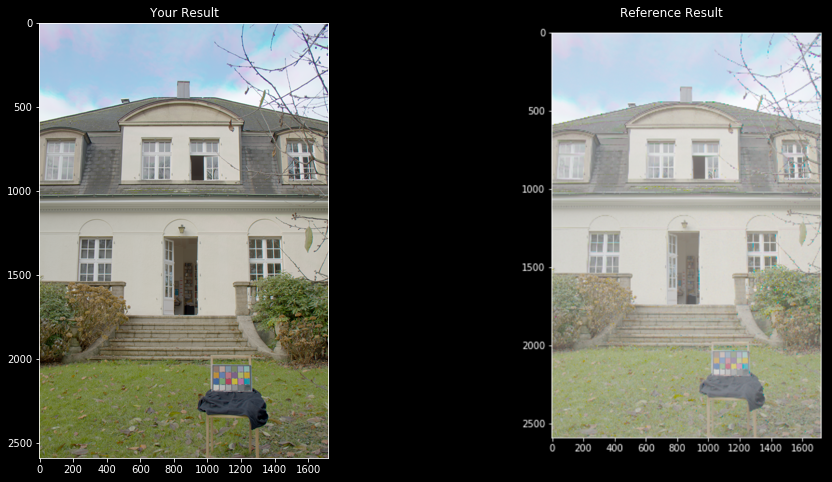

In [49]:
# Define the tonemapping algorithm described above
def tmLog2(x, stops):
    # hdr = x.copy()
    # hoch = np.max(hdr[:])
    # eM: machine Epsilon, Genauigkeit der float Berechnung. (eps = numpy.finfo(float).eps)
    # hdr = lambda hdr, stops: log2(max(x/max(x))) / stops  + 1
    # hdr[:] = ( np.log2(np.maximum(hdr[:] / hoch, np.finfo(float).eps)) / stops ) + 1
    # np.maximum(hdr_lum, np.finfo(float).eps)
    return ( np.log2(np.maximum(x[:] / np.max(x[:]), np.finfo(float).eps)) / stops ) + 1

print(img.shape)
print(tmLog2(img, stops).shape)

# How many stops below white do we want to see?
stops = 10

# Plot the result
plt.subplot(1,2,1)
# plt.figure(figsize=(12, 8))
plt.imshow( tmLog2( img, stops ).clip(0.0,1.0), interpolation = 'catrom' )
# reference result mit stops = 15 ausgeführt. mit Stops = 10 deutlich klareres Bild.
plt.title("Your Result")
plt.subplot(1,2,2)
fig = plt.imshow( plt.imread( "results_for_reference/TM_simple_log_result.png" ), interpolation = 'catrom' )
plt.axis('off')
plt.title("Reference Result");

### 4.1.2 Exposure in linear/logarithmic

Finish the anonymous function TM_Exposure that allows you to change exposure before display:
\begin{equation*}
y = x * 2^{P_{exposure}} \\ \\
x\in\mathbb{R}^+, P_{exposure}\in\mathbb{R}
\end{equation*}

You can also change exposure in log space. Implement the TM_Exposure function a second time:
\begin{equation*}
y = 2^{\log_2(\max(\epsilon_M, x)) + P_{exposure}} \\ \\
x\in\mathbb{R}^+, P_{exposure}\in\mathbb{R}, \epsilon_M \in\mathbb{R}+
\end{equation*}

You should get the exact same results for both formulas.

In [45]:
def tmExposure(x, exposure):
    return x * 2**exposure
def tmExposureLog(x, exposure):
    return 2 ** (np.log2(max(x)) + exposure)

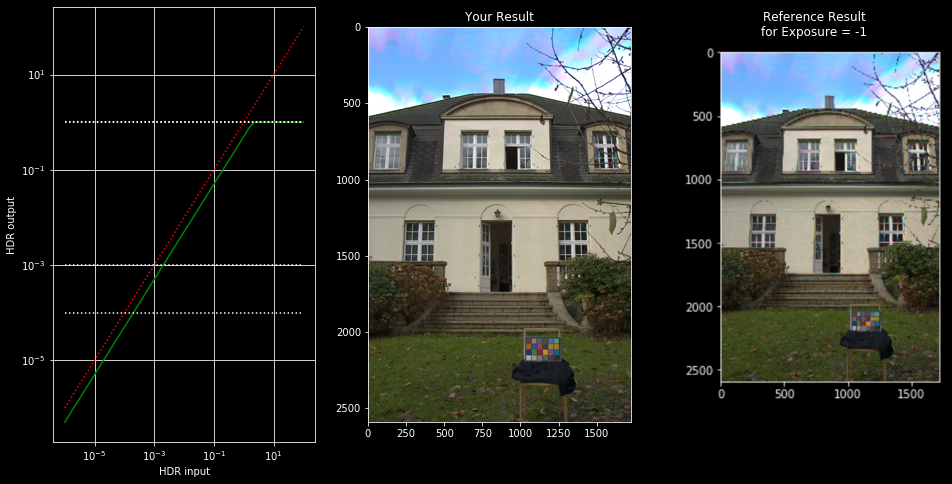

In [46]:
# Play around with exposure
exposure = -1

# Plot
plt.subplot(1,3,1)
x = np.logspace(-6, 2)
# Exchange for "tmExposureLog". Are the results the same?
curvePlot(x, tmExposure(x, exposure).clip(0.0,1.0))

plt.subplot(1,3,2)
plt.imshow( lin2srgb( tmExposure( img, exposure ).clip( 0.0, 1.0 ) ), interpolation = 'catrom' )
plt.title("Your Result");

plt.subplot(1,3,3)
fig = plt.imshow( plt.imread( "results_for_reference/TM_only_exposure_result.png" ), interpolation = 'catrom' )
plt.axis('off')
plt.title("Reference Result\nfor Exposure = -1");


### 4.1.3 Change contrast

Finish the anonymous function TM_Contrast that changes the contrast of an image:

\begin{equation*}
c_{pivot} = median(x) \\ \\
y = 2^{(\log_2(\max(\epsilon_M, x)) - \log_2(c_{pivot})) * P_{contrast} + \log_2(c_{pivot})} \\ \\
x\in\mathbb{R}^+, P_{contrast}\in\mathbb{R}^+, \epsilon_M \in\mathbb{R}+
\end{equation*}

In [ ]:
# We typically need some additional contrast to like images
contrast = 1.3

def tmContrast(x, mid_con):
    return # Your code here

# Plot
plt.subplot(1,3,1)
x = np.logspace(-6, 2)
curvePlot(x, tmContrast(x, contrast).clip(0.0,1.0))

plt.subplot(1,3,2)
plt.imshow(lin2srgb(tmContrast(img, contrast).clip(0.0,1.0)), interpolation = 'catrom')
plt.title("Your Result");

plt.subplot(1,3,3)
fig = plt.imshow( plt.imread( "results_for_reference/TM_only_contrast_result.png" ), interpolation = 'catrom' )
plt.axis('off')
plt.title("Reference Result\nfor Contrast = 1.3");

### 4.1.4 Combining exposure and contrast

Play with exposure and contrast and observe how the combined function behaves.

In [ ]:
# Let's combine contrast and exposure by conatenating both functions
contrast = 1.3
exposure = -2.5

def tmCombined(x, exposure, contrast):
    return tmContrast( tmExposure(x, exposure), contrast )

# Plot
plt.subplot(1,3,1)
x = np.logspace(-6, 2)
curvePlot(x, tmCombined(x, exposure, contrast).clip(0.0,1.0))

plt.subplot(1,3,2)
plt.imshow(lin2srgb( tmCombined(img, exposure, contrast).clip(0.0,1.0)), interpolation = 'catrom')
plt.title("Your Result");

plt.subplot(1,3,3)
fig = plt.imshow( plt.imread( "results_for_reference/TM_exposure_and_contrast_result.png" ), interpolation = 'catrom' )
plt.axis('off')
plt.title("Reference Result\nfor Exposure = -2\n and Contrast = 1.3");

### 4.1.5 A method for lowlight compression

Finish the anonymous function LowLightCompression:

\begin{equation*}
y = x + 2^{-P_{stops\_below\_white}} \\ \\
x\in\mathbb{R}^+, P_{stops\_below\_white}\in\mathbb{R}^+
\end{equation*}

This has the same result as adding a constant amount of flare.

In [ ]:
# The blacks look a little crushed. Maybe compress them using the formula above?
contrast = 1.3
exposure = 0
stops_below_white = 8

def tmLowlightCompression(x, stops_below_white):
    return # Your code here

def tmCombined(x, exposure, contrast, stops_below_white):
    return # Your code here

# Plot
plt.subplot(1,3,1)
x = np.logspace(-6, 2)
curvePlot(x, tmCombined(x, exposure, contrast, stops_below_white).clip(0.0,1.0))

plt.subplot(1,3,2)
plt.imshow(lin2srgb( tmCombined(img, exposure, contrast, stops_below_white).clip(0.0,1.0)), interpolation = 'catrom')
plt.title("Your Result");

plt.subplot(1,3,3)
fig = plt.imshow( plt.imread( "results_for_reference/TM_exposure_contrast_and_lowlightComp_result.png" ), interpolation = 'catrom' )
plt.axis('off')
plt.title("Reference Result\nfor Exposure = 0,\nContrast = 1.3 and\nStops below white = 8");

### 4.1.6 A method for highlight compression

Finish the anonymous function HighLightCompression:
\begin{equation*}
y = \frac{x}{1 + x} ~, ~ ~ ~ ~ 
x\in\mathbb{R}^+
\end{equation*}

Find the values for the three parameters contrast, exposure and stopsBelowWhite that result in a pleasing rendering for you.

In [ ]:
# Now that we can see the inside of the house - how about the highlights?
contrast = 1.3
exposure = 0
stops_below_white = 8

def tmHighlightCompression(x):
    return # Your code here

def tmCombined(x, exposure, contrast, stops_below_white):
    return tmHighlightCompression(tmLowlightCompression(tmContrast(tmExposure(x, exposure), contrast), stops_below_white))

# Plot
plt.subplot(1,3,1)
x = np.logspace(-6, 2)
curvePlot(x, tmCombined(x, exposure, contrast, stops_below_white).clip(0.0,1.0))

plt.subplot(1,3,2)
plt.imshow(lin2srgb(tmCombined(img, exposure, contrast, stops_below_white).clip(0.0,1.0)), interpolation = 'catrom')
plt.title("Your Result");

plt.subplot(1,3,3)
fig = plt.imshow( plt.imread( "results_for_reference/TM_exposure_contrast_lowlightComp_and_highlightComp_result.png" ), interpolation = 'catrom' )
plt.axis('off')
plt.title("Reference Result\nfor Exposure = 0,\n Contrast = 1.3,\nStops below white = 8 and\nHighlight Compression");

### 4.1.7 Tone mapping RGB vs luma

Compare and describe the different results for 5.1.6 and 5.1.7. Explain why mapping intensity gives a different result than mapping the individual channels R, G and B.

In [ ]:
# Explain why mapping the idividual r,g,b color channels can introduce hue shifts. Let's try to only map luminance and add the original color to the mapped luminance afeter tonemapping
#
#

contrast = 1.3
exposure = 0
stops_below_white = 8

hdr_lum =  # Your code here
sdr_lum =  # Your code here
hdr_lum = np.maximum(hdr_lum, np.finfo(float).eps)  # Limit hdr-luminance to only have values above eps

tonemapped_rgb =  # Your code here

# Plot
plt.subplot(1,3,1)
x = np.logspace(-6, 2)
curvePlot(x, tmCombined(x, exposure, contrast, stops_below_white).clip(0.0,1.0))

plt.subplot(1,3,2)
plt.imshow( lin2srgb( tonemapped_rgb.clip(0.0,1.0) ) )
plt.title("Your Result");

plt.subplot(1,3,3)
fig = plt.imshow( plt.imread( "results_for_reference/TM_exposure_contrast_lowlightComp_and_highlightComp_on_luminance_result.png" ) )
plt.axis('off')
plt.title("Reference Result\nfor Exposure = 0,\n Contrast = 1.3,\nStops below white = 8 and\nHighlight Compression, all\non luminance");

# What are the visual differences between mapping r,g,b individually and only mapping luminance. Do the highlights and midtones react differently? Explain why.
#
#
#

## 4.2 Color grading

Color grading systems have a large number of specialized grading controls. The most basic ones are specified in the ASC document: '*ASC Color Decision List (ASC CDL) Transfer Functions and Interchange Syntax*'. 
* Add an achromatic ramp and a 75% color bars to the ‘peppers.png’ image.
* Implement the functions (in the order proposed in the ASC-CDL document. Remember that Slope, Offset and Power can have different values for R, G and B.)
  * Slope
  * Offset
  * Power
  * Saturation
* Display the Haus image above and play with the grading controls - after tonemapping and before tonemapping.

In [ ]:
# Implement ASC-CDL Formulas
def luma(x):
    return  # Your code here

def ascSlope(x, slope):
    return  # Your code here

def ascOffset(x, offset):
    return  # Your code here

def ascPower(x, power):
    return  # Your code here

def ascSaturation(x, saturation):
    return  # Your code here

def ascGrade(x, slope, offset, power, saturation):
    return  # Your code here (concatenate all in the right order)

In [ ]:
# Grade after tonemapping

# Tonemapping Params:
exposure = 0
contrast = 1.3
stops_below_white = 8

# Grading Params
slope  = [1.2, 1.2, 1.2]
offset = [-0.07, -0.07, -0.07]
power  = [1.2, 1.2, 1.2]
saturation = 1.3

def tmCombined(x, exposure, contrast, stops_below_white):
    return tmHighlightCompression( tmLowlightCompression( tmContrast( tmExposure(x, exposure), contrast), stops_below_white) )

plt.imshow( ascGrade( lin2srgb( tmCombined( img, exposure, contrast, stops_below_white ) ), slope, offset, power, saturation ).clip(0.0,1.0) );

In [ ]:
# These are the ARRI LogCv3 Formulas
def lin2logc(x):
    return np.multiply(x > 0.010591, 0.24719 * np.log10(5.555556 * x + 0.052272) + 0.385537) + np.multiply(x <= 0.010591, 5.367655 * x + 0.092809)
def logc2lin(x):
    return np.multiply(x > 0.149659, (np.power(10.0, (x - 0.385537) / 0.247189) - 0.052272) / 5.555556) + np.multiply(x <= 0.149659, (x - 0.092809) / 5.367650)

In [ ]:
slope  = [1.2, 1.2, 1.2]
offset = [-0.07, -0.07, -0.07]
power  = [1.2, 1.2, 1.2]
sat    = 1.3

img_graded = ascGrade( lin2logc( img ), slope, offset, power, sat )
img_graded[np.isnan(img_graded)] = 0.0

plt.subplot(1,2,1)
plt.imshow( lin2srgb( tmCombined( logc2lin( img_graded ), exposure, contrast, stops_below_white).clip(0.0,1.0) ) )
plt.title("Grading in LogC nonlinearity before mapping")

plt.subplot(1,2,2)
plt.imshow( ascGrade( lin2srgb( tmCombined( img, exposure, contrast, stops_below_white).clip(0.0,1.0)), slope, offset, power, sat).clip(0.0,1.0) );
plt.title("Grading in sRGB nonlinearity after mapping");

# What do you like about grading before the mapping, what do you prefer about grading after the mapping?
#
#

## 4.3 Bonus: Implement another TMO

Maybe one of these:
* `TM_Biswas_Pattanaik05`: Biswas, K. K., & Pattanaik, S. (2005). A simple spatial tone mapping operator for high dynamic range images. Proc. IS&T/SID’s 13th Color Imaging Conference.
* `TM_Drago03`: Drago, F., Myszkowski, K., Annen, T., & Chiba, N. (2003). Adaptive Logarithmic Mapping For Displaying High Contrast Scenes. Computer Graphics Forum.
* `TM_Uncharted2`: Hable, J. (2010). Uncharted 2: HDR lighting. Game Developers Conference.

Or another tone mapping operator you are interested in. Wikipedia has a great overview on tone mapping operators.